In [1]:
#@title Installs
!pip install -q uv
!uv pip install -q --system "jax[cuda12]"
!uv pip install -q --system git+https://github.com/jax-md/jax-md.git
!uv pip install -q --system git+https://www.github.com/deepmind/haiku
!uv pip install -q --system git+https://www.github.com/deepmind/optax
!uv pip install -q --system pymatgen
!uv pip install -q --system mdtraj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 104.5 MB/s eta 0:00:00


In [2]:
#@title Imports
import pickle
import os
import numpy as onp
import copy
from jax import config
config.update('jax_enable_x64', True)

from typing import Callable, Tuple, TextIO, Dict, Any, Optional
import jax.numpy as jnp
import numpy as onp
import optax
from jax import jit, checkpoint
from jax import grad
from jax import vmap
from jax import random
from jax import lax
from jax import checkpoint, value_and_grad
from jax import jacfwd, jacrev, linearize
from jax import hessian
from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import energy, elasticity
from jax_md import partition
from jax_md import quantity, util, smap, units
from jax_md.util import f32, f64
from jax.scipy.optimize import minimize as jax_min
from scipy.optimize import minimize as scipy_min

import time
from typing import Callable, Tuple, TextIO, Dict, Any, Optional
from functools import wraps, partial
import pandas as pd
import mdtraj as md
# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
# Matplotlib plot settings
# plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 14})
import pickle
import os
import numpy as onp
import copy
from jax import config
config.update('jax_enable_x64', True)

from typing import Callable, Tuple, TextIO, Dict, Any, Optional
import jax.numpy as jnp
import numpy as onp
import optax
from jax import jit, checkpoint
from jax import grad
from jax import vmap
from jax import random
from jax import lax
from jax import checkpoint, value_and_grad
from jax import jacfwd, jacrev, linearize
from jax import hessian
from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import energy, elasticity
from jax_md import partition
from jax_md import quantity, util, smap, units
from jax_md.util import f32, f64
from jax.scipy.optimize import minimize as jax_min
from scipy.optimize import minimize as scipy_min

import time
from typing import Callable, Tuple, TextIO, Dict, Any, Optional
from functools import wraps, partial
import pandas as pd

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
# Matplotlib plot settings
# plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 14})
from pymatgen.io.vasp.outputs import Xdatcar

In [3]:
#@title Helper functions
def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_facecolor('white')
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def draw_training(params,i):
  # display.clear_output(wait=True)
  # display.display(plt.gcf())
  fig = plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.semilogy(train_error_save)
  plt.semilogy(val_error_save)
  plt.xlim([0, train_epochs])
  format_plot(r'Epoch', '$L$')
  plt.subplot(1, 2, 2)
  predicted = vectorized_energy_fn(params, example_positions)
  plt.plot(example_energies, predicted, 'o')
  plt.plot(jnp.linspace(-400, -300, 10), jnp.linspace(-400, -300, 10), '--')
  format_plot('$E_{label}$ $(eV)$', '$E_{predicted}$ $(eV)$')
  # finalize_plot((2, 1))
  plt.savefig(f"loss_prediction_{i}.png",dpi=300)
  plt.close()

def lattice(R_unit_cell, copies, lattice_vectors):
  """Repeats a unit cell along lattice vectors. """
  lattice_vectors = onp.array(lattice_vectors, f64)

  N, d = R_unit_cell.shape
  if isinstance(copies, int):
    copies = (copies,) * d

  if lattice_vectors.ndim == 0 or lattice_vectors.ndim == 1:
    cartesian = True
    L = onp.eye(d) * lattice_vectors[onp.newaxis, ...]
  elif lattice_vectors.ndim == 2:
    assert lattice_vectors.shape[0] == lattice_vectors.shape[1]
    cartesian = False
    L = onp.eye(d) / onp.array(copies)[onp.newaxis, ...]
    R_unit_cell /= onp.array(copies)[onp.newaxis, ...]
  else:
    raise ValueError()

  Rs = []
  for indices in onp.ndindex(copies):
    dR = 0.
    for idx, i in enumerate(indices):
      dR += i * L[idx]
    R = R_unit_cell + dR[onp.newaxis, :]
    Rs += [R]

  return onp.concatenate(Rs)

# Data Loading.
def MD_trajectory_reader(f, no_skip=20):
  filename = os.path.join('/content/Supplementary/', f)
  fo = open(filename, 'r')
  samples = fo.read().split('iter= ')[1:]
  steps = []
  lattice_vectors = []
  positions = []
  forces = []
  temperatures = []
  energies = []
  for sample in samples[::no_skip]:
    entries = sample.split('\n')
    steps.append(int(entries[0]))
    lattice_vectors.append(onp.array([list(map(float, lv.split())) for lv in entries[1:4]]))
    assert entries[4]=='64'
    temp = onp.array([list(map(float, lv.split()[1:])) for lv in entries[5:69]])
    positions.append(temp[:,:3])
    forces.append(temp[:,3:])
    remaining_lines = entries[69:]
    temperatures.append(float([entry for entry in entries[69:] if 'Temp' in entry ][0].split('=')[1].split()[0]))
    energies.append(float([entry for entry in entries[69:] if 'el-ion E' in entry ][0].split('=')[1].split()[0]))
  assert (len(set(steps))-(steps[-1]-steps[0]+1)/no_skip) < 1
  return jnp.array(positions), jnp.array(energies), jnp.array(forces), jnp.array(lattice_vectors)

def build_dataset():
  no_skip = 15

  data300_cubic, energies300_cubic, forces300_cubic, latvec300_cubic = MD_trajectory_reader(
      'MD_DATA.cubic_300K', no_skip=no_skip)
  data600_cubic, energies600_cubic, forces600_cubic, latvec600_cubic = MD_trajectory_reader(
      'MD_DATA.cubic_600K', no_skip=no_skip)
  data900_cubic, energies900_cubic, forces900_cubic, latvec900_cubic = MD_trajectory_reader(
      'MD_DATA.cubic_900K', no_skip=no_skip)

  data_liq, energies_liq, forces_liq, latvec_liq = MD_trajectory_reader(
      'MD_DATA.liq_1', no_skip=no_skip)

  all_data = jnp.vstack((data300_cubic, data600_cubic, data900_cubic,
                         data_liq))

  all_energies = jnp.hstack((energies300_cubic, energies600_cubic, energies900_cubic,
                             energies_liq))

  all_forces = jnp.vstack((forces300_cubic, forces600_cubic, forces900_cubic,
                           forces_liq))

  all_latvec = jnp.vstack((latvec300_cubic, latvec600_cubic, latvec900_cubic,
                           latvec_liq))

  noTotal = all_data.shape[0]

  onp.random.seed(0)
  II = onp.random.permutation(range(noTotal))

  # Shuffle the data
  all_data = all_data[II]
  all_energies = all_energies[II]
  all_forces = all_forces[II]
  all_latvec = all_latvec[II]

  noTr = int(noTotal * 0.60)
  noVa = int(noTotal * 0.20)
  noTe = noTotal - (noTr + noVa)
  train_data = all_data[:noTr]
  val_data = all_data[noTr:noTr + noVa]
  test_data = all_data[noTr + noVa:]

  train_energies = all_energies[:noTr]
  val_energies = all_energies[noTr:noTr + noVa]
  test_energies = all_energies[noTr + noVa:]

  train_forces = all_forces[:noTr]
  val_forces  = all_forces[noTr:noTr + noVa]
  test_forces = all_forces[noTr + noVa:]

  train_latvec = all_latvec[:noTr]
  val_latvec  = all_latvec[noTr:noTr + noVa]
  test_latvec = all_latvec[noTr + noVa:]

  data_set = ((train_data, train_energies, train_forces, train_latvec),
              (val_data, val_energies, val_forces, val_latvec),
              (test_data, test_energies, test_forces, test_latvec))

  print(f"Train data = {len(train_data)}, Validation data = {len(val_data)}, Test data = {len(test_data)}")
  return data_set

def write_lammps_data(positions, box_size, filename="structure.dat"):
    """
    Write atomic positions to a LAMMPS data file.

    Args:
        positions: Array of atomic positions with shape (n_atoms, 3)
        box_size: Array/list of box dimensions [Lx, Ly, Lz]
        filename: Output filename
    """
    n_atoms = len(positions)

    with open(filename, 'w') as f:
        # Header
        f.write("LAMMPS data file from JAX-MD simulation\n\n")

        # System properties
        f.write(f"{n_atoms} atoms\n")
        f.write("1 atom types\n\n")

        # Box dimensions
        f.write(f"0.0 {box_size[0, 0]} xlo xhi\n")
        f.write(f"0.0 {box_size[1, 1]} ylo yhi\n")
        f.write(f"0.0 {box_size[2, 2]} zlo zhi\n\n")

        # Atomic positions
        f.write("Atoms # atomic\n\n")
        for i, pos in enumerate(positions):
            # Format: atom-ID atom-type x y z
            f.write(f"{i+1} 1 {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")

In [4]:
#@title Load data
!wget -q https://raw.githubusercontent.com/M3RG-IITD/Force-field-optimization/main/Si_DFT/Si_VASP_DFT_FC/XDATCAR

In [5]:
!wget https://pubs.aip.org/jcp/article-supplement/988620/zip/024104_1_supplements
!unzip -q 024104_1_supplements  # wrapper for `Supplementary.zip`.
!unzip -q Supplementary.zip

# You can download it manually from the website if this gives 403 error

--2025-03-11 14:16:15--  https://pubs.aip.org/jcp/article-supplement/988620/zip/024104_1_supplements
Resolving pubs.aip.org (pubs.aip.org)... 104.18.12.179, 104.18.13.179
Connecting to pubs.aip.org (pubs.aip.org)|104.18.12.179|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-03-11 14:16:15 ERROR 403: Forbidden.



In [6]:
train, val, test = build_dataset()
positions, energies, forces, latvec = train
val_positions, val_energies, val_forces, val_latvec = val
test_positions, test_energies, test_forces, test_latvec = test

Train data = 2578, Validation data = 859, Test data = 860


In [7]:
xdatcar = Xdatcar('/content/XDATCAR')
structures = xdatcar.structures

units = units.metal_unit_system()

energy_mean = jnp.mean(energies)
energy_std = jnp.std(energies)

print('positions.shape = {}'.format(positions.shape))
print('Average energy = {}'.format(energy_mean))

latvec_DFT = jnp.array([
    [structures[0].lattice.a, 0.00000, 0.00000],
    [0.00000, structures[0].lattice.b, 0.00000],
    [0.00000, 0.00000, structures[0].lattice.c]])
pos_DFT = jnp.array(structures[0].cart_coords, dtype=jnp.float64)

displacement_DFT, shift_DFT = space.periodic(latvec_DFT[0,0])

dr = 5/100
r = jnp.linspace(0.5, 5.5, 100, dtype=f64)

gr_fn_DFT = jit(quantity.pair_correlation(displacement_DFT, radii=r, sigma=4 * dr, compute_average=True))

gr_DFT = jnp.zeros((1000, 100))
for i in range(1000):
  gr_DFT = gr_DFT.at[i, :].set(gr_fn_DFT(structures[9000 + i].cart_coords))

fig = plt.figure(figsize=(8, 6))
plt.plot(r,jnp.mean(gr_DFT, axis=0) * quantity.volume(3, latvec_DFT) / 32, linewidth=3, label='VASP-DFT (liquid) 1.0ps')
plt.ylabel(r"$g(r)$", fontsize=16)
plt.xlabel(r"$r\ (\AA)$", fontsize=16)
plt.xlim([r[0], r[-1]])
plt.legend()
plt.savefig("RDF_liquid.png",dpi=300)
plt.close()

positions.shape = (2578, 64, 3)
Average energy = -364.64554060909614


In [8]:
#@title MD
def setup_md(R, latvec):
  dt = 1e-3 # fs
  steps = 200
  key = random.PRNGKey(0)
  key, split = random.split(key)
  write_every = 1
  dr = 5/100
  r = jnp.linspace(0.5, 5.5, 100, dtype=f64)
  T_init = 2000.0
  Mass = 28.0855 * units['mass']

  displacement, shift = space.periodic(latvec[0,0])
  gr_fn = jit(quantity.pair_correlation(displacement, radii=r, sigma=dr * 4))

  logger = {
        'gr': jnp.zeros((steps // write_every,) + r.shape),
        'pos': jnp.zeros((steps // write_every,) + R.shape)
        }
  @checkpoint
  def run(params):

    def step_fn(i, state_nbrs_log):
      state, nbrs, log = state_nbrs_log
      t = i * dt * units['time']
      # Log information about the simulation.
      gr_measured = jnp.mean(gr_fn(state.position),axis=0)
      log['gr'] =  log['gr'].at[i].set(gr_measured)
      log['pos'] = log['pos'].at[i].set(state.position)
      # Take a simulation step.
      state = apply_fn(state, neighbor=nbrs, kT=T_init * units['temperature'])
      # state = apply_fn(state, neighbor=nbrs)
      nbrs = nbrs.update(state.position, neighbor=nbrs)
      return state, nbrs, log


    neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec[0,0], A=params["A"], B=params["B"],sigma=params["sigma"] ,epsilon=params["epsilon"], lam=params["lam"], gamma=params["gamma"], cutoff=params["cutoff"])
    init_fn, apply_fn = simulate.nve(energy_fn, shift, dt=dt * units['time'], kT=T_init * units['temperature'])
    state = init_fn(key, R, neighbor=neighbor, kT=T_init * units['temperature'], mass=Mass)
    state_run, nbrs_run, log_run = lax.fori_loop(0, steps, step_fn, (state, neighbor, logger))

    return jnp.sum(jnp.power(jnp.mean(log_run['gr'], axis=0) - gr_converged, 2)) /  jnp.sum(jnp.power(gr_converged, 2)), log_run
  return run

def setup_md_grad(R, latvec):
  dt = 1e-3 # fs
  steps = 200
  key = random.PRNGKey(0)
  key, split = random.split(key)
  write_every = 1
  dr = 5/100
  r = jnp.linspace(0.5, 5.5, 100, dtype=f64)
  T_init = 2000.0
  Mass = 28.0855 * units['mass']

  displacement, shift = space.periodic(latvec[0,0])
  gr_fn = jit(quantity.pair_correlation(displacement, radii=r, sigma=dr * 4))

  logger = {
        'gr': jnp.zeros((steps // write_every,) + r.shape)
        }
  @checkpoint
  def run(params):

    def step_fn(i, state_nbrs_log):
      state, nbrs, log = state_nbrs_log
      t = i * dt * units['time']
      # Log information about the simulation.
      gr_measured = jnp.mean(gr_fn(state.position),axis=0)
      log['gr'] =  log['gr'].at[i].set(gr_measured)
      # Take a simulation step.
      state = apply_fn(state, neighbor=nbrs, kT=T_init * units['temperature'])
      # state = apply_fn(state, neighbor=nbrs)
      nbrs = nbrs.update(state.position, neighbor=nbrs)
      return state, nbrs, log

    neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec[0,0], A=params["A"], B=params["B"], sigma=params["sigma"], epsilon=params["epsilon"], lam=params["lam"], gamma=params["gamma"], cutoff=params["cutoff"])
    init_fn, apply_fn = simulate.nve(energy_fn, shift, dt=dt * units['time'], kT=T_init * units['temperature'])
    state = init_fn(key, R, neighbor=neighbor, kT=T_init * units['temperature'], mass=Mass)
    state_run, nbrs_run, log_run = lax.fori_loop(0, steps, step_fn, (state, neighbor, logger))

    return jnp.sum(jnp.power(jnp.mean(log_run['gr'], axis=0) - gr_converged, 2)) /  jnp.sum(jnp.power(gr_converged, 2))
  return run

In [9]:
box_size = jnp.array([10.862, 10.862, 10.862])  # The size of the simulation region.
displacement, shift = space.periodic(box_size[0])

DFT_pos = jnp.array(structures[9800].cart_coords, dtype=jnp.float64)

gr_DFT_con = jnp.zeros((200, 100))
for i in range(200):
  gr_DFT_con = gr_DFT_con.at[i, :].set(gr_fn_DFT(structures[9800 + i].cart_coords))

gr_converged = jnp.mean(gr_DFT_con, axis=0)

neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, box_size[0])
neighbor = neighbor_fn.allocate(positions[0], extra_capacity=6)
print('Allocating space for at most {} edges'.format(neighbor.idx.shape[1]))

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Allocating space for at most 26 edges


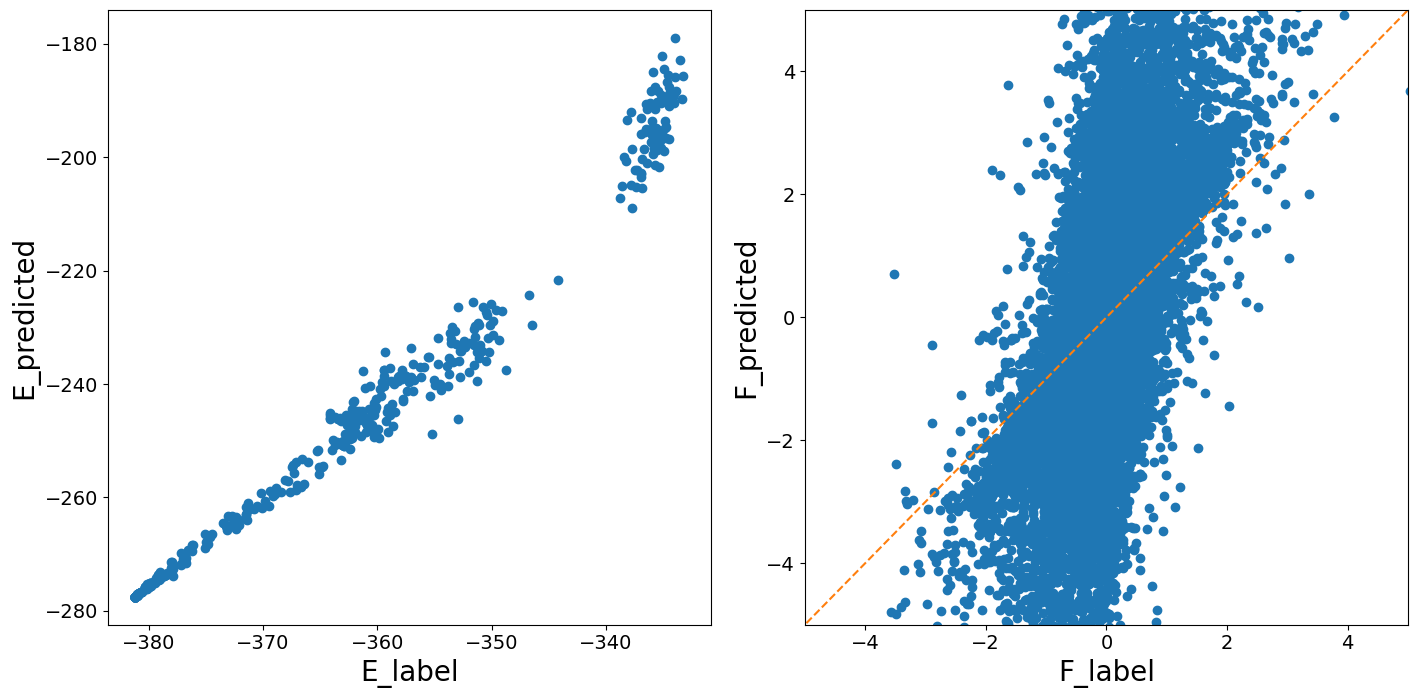

In [10]:
@jit
def train_energy_fn(params, R):
  energy_fn = energy.stillinger_weber(displacement, A=params["A"], B=params["B"],
                                      sigma=params["sigma"],epsilon=params["epsilon"],
                                      lam=params["lam"], gamma=params["gamma"], cutoff=params["cutoff"])
  return energy_fn(R)

# Vectorize over states, not parameters.
vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

grad_fn = grad(train_energy_fn, argnums=1)
force_fn = lambda params, R, **kwargs: -grad_fn(params, R)
vectorized_force_fn = vmap(force_fn, (None, 0))

key = random.PRNGKey(0)

params = {"A": 7.049556277,
          "B": 0.6022245584,
          "sigma":2.0951,
          "epsilon": 2.16826,
          "lam": 21.0,
          "gamma": 1.2,
          "cutoff": 3.77118}
params_og = params.copy()
run_md = jit(setup_md(DFT_pos, latvec_DFT))
run = setup_md_grad(DFT_pos, latvec_DFT)

n_predictions = 500
example_positions = positions[:n_predictions]
example_energies = energies[:n_predictions]
example_forces = forces[:n_predictions]

predicted = vmap(train_energy_fn, (None, 0))(params, example_positions)

plt.subplot(1, 2, 1)
predicted_energies = vectorized_energy_fn(params, example_positions)
plt.plot(example_energies, predicted_energies, 'o')
format_plot('E_label', 'E_predicted')
plt.subplot(1, 2, 2)
predicted_forces = vectorized_force_fn(params, val_positions[:300])
plt.plot(val_forces[:300].reshape((-1,)),
         predicted_forces.reshape((-1,)),
         'o')
plt.plot(jnp.linspace(-6, 6, 20), jnp.linspace(-6, 6, 20), '--')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
format_plot('F_label', 'F_predicted')
finalize_plot((2, 1))
plt.savefig(f"EF_before.png",dpi=300)

In [11]:
@jit
def energy_loss(params, R, energy_targets):
  return jnp.mean((vectorized_energy_fn(params, R) - energy_targets) ** 2)

@jit
def force_loss(params, R, force_targets):
  dforces = vectorized_force_fn(params, R) - force_targets
  return jnp.mean(jnp.sum(dforces ** 2, axis=(1, 2)))

@jit
def loss(params, R, targets):
  return energy_loss(params, R, targets[0]) + force_loss(params, R, targets[1]) + 2000*run(params)

opt = optax.chain(optax.clip_by_global_norm(1.0),
                  optax.adam(1e-4))

@jit
def update_step(params, opt_state, R, labels):
  updates, opt_state = opt.update(jacfwd(loss)(params, R, labels),
                                  opt_state)
  return optax.apply_updates(params, updates), opt_state

@jit
def update_epoch(params_and_opt_state, batches):
  def inner_update(params_and_opt_state, batch):
    params, opt_state = params_and_opt_state
    b_xs, b_labels = batch

    return update_step(params, opt_state, b_xs, b_labels), 0
  return lax.scan(inner_update, params_and_opt_state, batches)[0]

dataset_size = positions.shape[0]
batch_size = 64

lookup = onp.arange(dataset_size)
onp.random.shuffle(lookup)

@jit
def make_batches(lookup):
  batch_Rs = []
  batch_Es = []
  batch_Fs = []

  for i in range(0, len(lookup), batch_size):
    if i + batch_size > len(lookup):
      break

    idx = lookup[i:i + batch_size]

    batch_Rs += [positions[idx]]
    batch_Es += [energies[idx]]
    batch_Fs += [forces[idx]]

  return jnp.stack(batch_Rs), jnp.stack(batch_Es), jnp.stack(batch_Fs)

batch_Rs, batch_Es, batch_Fs = make_batches(lookup)

train_epochs = 50

opt_state = opt.init(params)

In [12]:
train_error_save = []
train_energy_error_save = []
train_force_error_save = []
train_rdf_error_save = []

val_error_save = []
val_energy_error_save = []
val_force_error_save = []
val_rdf_error_save = []

best_val_error = jnp.inf
best_val_energy_error = jnp.inf
best_val_force_error = jnp.inf
best_val_rdf_error = jnp.inf
best_params = None
for iteration in range(train_epochs):

  train_error = float(jnp.sqrt(loss(params, batch_Rs[0], (batch_Es[0], batch_Fs[0]))))
  train_energy_error = float(jnp.sqrt(energy_loss(params, batch_Rs[0], batch_Es[0])))
  train_force_error = float(jnp.sqrt(force_loss(params, batch_Rs[0], batch_Fs[0])))
  train_rdf_error = float(run(params))

  train_error_save += [train_error]
  train_energy_error_save += [train_energy_error]
  train_force_error_save += [train_force_error]
  train_rdf_error_save += [train_rdf_error]

  val_error = float(jnp.sqrt(loss(params, val_positions, (val_energies, val_forces))))
  val_energy_error = float(jnp.sqrt(energy_loss(params, val_positions, val_energies)))
  val_force_error = float(jnp.sqrt(force_loss(params, val_positions, val_forces)))
  val_rdf_error = float(run(params))

  val_error_save += [val_error]
  val_energy_error_save += [val_energy_error]
  val_force_error_save += [val_force_error]
  val_rdf_error_save += [val_rdf_error]

  if iteration % 10 == 0:
    _, log = run_md(params)
    gr = log['gr']
    fig = plt.figure(figsize=(8, 6))
    plt.plot(r, jnp.mean(gr_DFT, axis=0), linewidth=3, label='VASP-DFT')
    plt.plot(r, jnp.mean(gr, axis=0), linewidth=2, label='SW')
    plt.ylabel(r"$g(r)$", fontsize=16)
    plt.xlabel(r"$r\ (\AA)$", fontsize=16)
    plt.xlim([r[0], r[-1]])
    plt.legend()
    plt.savefig(f"RDF_{iteration}.png",dpi=300)
    plt.close()
    draw_training(params, iteration)
    print(f"Iteration: {iteration} Train error: {train_error:.3E} Test error: {val_error:.3E}")

  if val_error < best_val_error:
    best_val_error = val_error
    best_params = copy.deepcopy(params)
    best_val_energy_error = val_energy_error
    best_val_force_error = val_force_error
    best_val_rdf_error = val_rdf_error

  if iteration % 10 == 0:
    with open(f'si_SW_rdf_{int(iteration / 10)}.pickle', 'wb') as f:
      params_d = pickle.dump(params, f)


  params, opt_state = update_epoch((params, opt_state),
                                   (batch_Rs, (batch_Es, batch_Fs)))

  onp.random.shuffle(lookup)
  batch_Rs, batch_Es, batch_Fs = make_batches(lookup)

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Iteration: 0 Train error: 1.160E+02 Test error: 1.170E+02
Iteration: 10 Train error: 6.905E+01 Test error: 6.761E+01
Iteration: 20 Train error: 2.506E+01 Test error: 2.275E+01
Iteration: 30 Train error: 1.447E+01 Test error: 1.445E+01
Iteration: 40 Train error: 1.274E+01 Test error: 1.337E+01


In [13]:
print(f"Iteration: {iteration} Train error: {train_error:.3E} Test error: {val_error:.3E}")
print(f"Best -> Test error = {best_val_error:.3E}, Energy error = {best_val_energy_error:.3E}, Force error = {best_val_force_error:.3E}, RDF error = {best_val_rdf_error:.3E}")

Iteration: 49 Train error: 1.200E+01 Test error: 1.286E+01
Best -> Test error = 1.286E+01, Energy error = 3.412E+00, Force error = 1.204E+01, RDF error = 4.400E-03


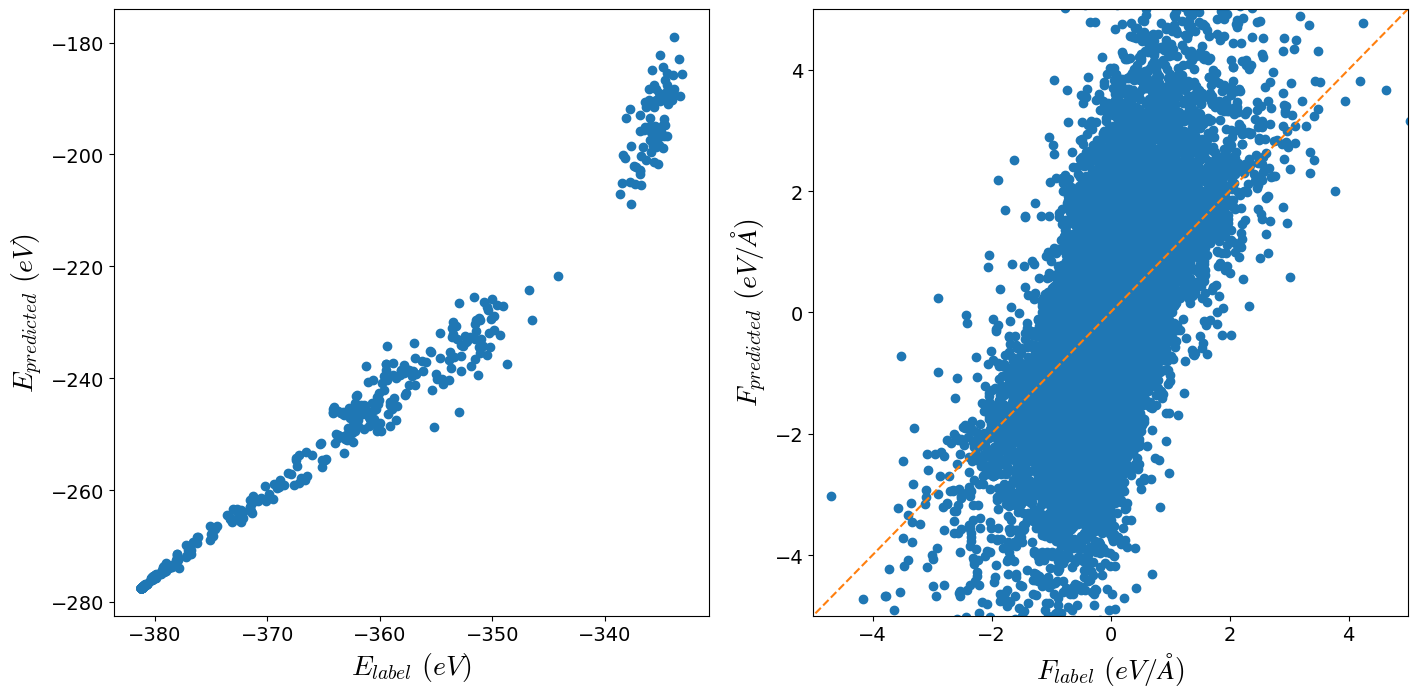

In [14]:
plt.subplot(1, 2, 1)
plt.plot(example_energies, predicted_energies, 'o')
format_plot(r'$E_{label}$ $(eV)$', '$E_{predicted}$ $(eV)$')
plt.subplot(1, 2, 2)
predicted_forces = vectorized_force_fn(best_params, val_positions[:300])
plt.plot(val_forces[:300].reshape((-1,)), predicted_forces.reshape((-1,)), 'o')
plt.plot(jnp.linspace(-6, 6, 20), jnp.linspace(-6, 6, 20), '--')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
format_plot(r'$F_{label}$ $(eV/\AA)$', '$F_{predicted}$ $(eV/\AA)$')
finalize_plot((2, 1))
plt.savefig(f"EF_after.png",dpi=300)

_, log = run_md(best_params)
gr = log['gr']
fig = plt.figure(figsize=(8, 6))
plt.plot(r, jnp.mean(gr_DFT, axis=0), linewidth=3, label='VASP-DFT')
plt.plot(r, jnp.mean(gr, axis=0), linewidth=2, label='SW')
plt.ylabel(r"$g(r)$", fontsize=16)
plt.xlabel(r"$r\ (\AA)$", fontsize=16)
plt.xlim([r[0], r[-1]])
plt.legend()
plt.savefig(f"RDF_{iteration}.png",dpi=300)
plt.close()
draw_training(best_params, iteration)

with open('si_SW_rdf_best.pickle', 'wb') as f:
	params_d = pickle.dump(best_params, f)

In [15]:
def compute_rdf_mdt(positions, box_size, r_range=(0.001, 5.501), bin_width=0.025):
    """Compute radial distribution function using MDTraj.

    Args:
        positions: Array of shape (n_frames, n_atoms, 3) containing atomic positions
        box_size: Size of periodic box
        r_range: Tuple of (min_r, max_r) for RDF calculation
        bin_width: Width of RDF bins

    Returns:
        r: Array of radii values
        g_r: Array of RDF values
    """

    # Convert positions to nanometers for MDTraj
    positions_nm = positions * 0.1  # Convert Angstrom to nm
    box_nm = box_size * 0.1

    # Create MDTraj trajectory object
    # cubic box
    unitcell_lengths = onp.tile([box_nm[0]], (len(positions), 3))
    unitcell_angles = onp.tile([90, 90, 90], (len(positions), 1))

    # Create topology with all atoms as the same type
    top = md.Topology()
    chain = top.add_chain()
    residue = top.add_residue('RES', chain)
    for i in range(positions.shape[1]):
        top.add_atom('Si', md.element.silicon, residue)

    # Create trajectory
    traj = md.Trajectory(positions_nm, top,
                        unitcell_lengths=unitcell_lengths,
                        unitcell_angles=unitcell_angles)

    # Calculate all pairs
    n_atoms = positions.shape[1]
    pairs = []
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            pairs.append([i,j])
    pairs = onp.array(pairs)

    # Compute RDF
    r, g_r = md.compute_rdf(traj, pairs,
                           r_range=(r_range[0]*0.1, r_range[1]*0.1),  # Convert to nm
                           bin_width=bin_width*0.1,  # Convert to nm
                           periodic=True)

    # Convert r back to Angstroms
    r = r * 10

    return r, g_r

In [16]:
#@title Longer MD
def setup_md_long(R, latvec):
  dt = 1e-3 # fs
  steps = 10000
  key = random.PRNGKey(0)
  key, split = random.split(key)
  write_every = 1
  dr = 5/100
  r = jnp.linspace(0.5, 5.5, 100, dtype=f64)
  T_init = 2000.0
  Mass = 28.0855 * units['mass']

  displacement, shift = space.periodic(latvec[0,0])
  gr_fn = jit(quantity.pair_correlation(displacement, radii=r, sigma=dr * 4))

  logger = {
        'gr': jnp.zeros((steps // write_every,) + r.shape),
        'pos': jnp.zeros((steps // write_every,) + R.shape)
        }
  @checkpoint
  def run(params):

    def step_fn(i, state_nbrs_log):
      state, nbrs, log = state_nbrs_log
      t = i * dt * units['time']
      # Log information about the simulation.
      gr_measured = jnp.mean(gr_fn(state.position),axis=0)
      log['gr'] =  log['gr'].at[i].set(gr_measured)
      log['pos'] = log['pos'].at[i].set(state.position)
      # Take a simulation step.
      state = apply_fn(state, neighbor=nbrs, kT=T_init * units['temperature'])
      # state = apply_fn(state, neighbor=nbrs)
      nbrs = nbrs.update(state.position, neighbor=nbrs)
      return state, nbrs, log


    neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec[0,0], A=params["A"], B=params["B"],sigma=params["sigma"] ,epsilon=params["epsilon"], lam=params["lam"], gamma=params["gamma"], cutoff=params["cutoff"])
    init_fn, apply_fn = simulate.nve(energy_fn, shift, dt=dt * units['time'], kT=T_init * units['temperature'])
    state = init_fn(key, R, neighbor=neighbor, kT=T_init * units['temperature'], mass=Mass)
    state_run, nbrs_run, log_run = lax.fori_loop(0, steps, step_fn, (state, neighbor, logger))

    return jnp.sum(jnp.power(jnp.mean(log_run['gr'], axis=0) - gr_converged, 2)) /  jnp.sum(jnp.power(gr_converged, 2)), log_run
  return run

In [17]:
!wget -q https://github.com/M3RG-IITD/Force-field-optimization/raw/refs/heads/main/Si_FF/Si_params_OPT/si_sw_rdf_final.pickle
!wget -q https://github.com/M3RG-IITD/Force-field-optimization/raw/refs/heads/main/Si_FF/Si_params_OPT/md_FT.lammpstrj
!wget -q https://github.com/M3RG-IITD/Force-field-optimization/raw/refs/heads/main/Si_FF/Si_params_OPT/md.lammpstrj

In [18]:
xdatcar = Xdatcar('/content/XDATCAR')
structures = xdatcar.structures

latvec_DFT = jnp.array([
    [structures[0].lattice.a, 0.00000, 0.00000],
    [0.00000, structures[0].lattice.b, 0.00000],
    [0.00000, 0.00000, structures[0].lattice.c]])

DFT_pos = jnp.array(structures[5000].cart_coords, dtype=jnp.float64)


In [19]:
run_md_long = jit(setup_md_long(DFT_pos, latvec_DFT))

In [20]:
xdatcar = Xdatcar('/content/XDATCAR')
structures = xdatcar.structures

write_lammps_data(DFT_pos, latvec_DFT, "initial_structure.dat")

with md.formats.LAMMPSTrajectoryFile('/content/md.lammpstrj') as f:
    pos_LAMMPS, box_length_LAMMPS, _ = f.read()

with md.formats.LAMMPSTrajectoryFile('/content/md_FT.lammpstrj') as f:
    pos_LAMMPS_rdf_ft, box_length_LAMMPS_rdf_ft, _ = f.read()

In [21]:
with open('/content/si_sw_rdf_final.pickle', 'rb') as f:
  params_si_rdf = pickle.load(f)

In [22]:
_, log = run_md_long(params_og)
_, log_rdf_ft = run_md_long(params_si_rdf)

In [23]:
box_size = jnp.array([latvec_DFT[0,0], latvec_DFT[1,1], latvec_DFT[2,2]], dtype=jnp.float64)
ref_pos_DFT = jnp.array([i.cart_coords for i in structures[5000:]], dtype=jnp.float64)
pos = log['pos']
pos_rdf_ft = log_rdf_ft['pos']

r_mdt_DFT, gr_mdt_DFT = compute_rdf_mdt(ref_pos_DFT, box_size)

r_mdt, gr_mdt = compute_rdf_mdt(pos, box_size)
r_mdt_rdf_ft, gr_mdt_rdf_ft = compute_rdf_mdt(pos_rdf_ft, box_size)

r_mdt_LAMMPS, gr_mdt_LAMMPS = compute_rdf_mdt(pos_LAMMPS, box_length_LAMMPS[0])
r_mdt_LAMMPS_rdf_ft, gr_mdt_LAMMPS_rdf_ft = compute_rdf_mdt(pos_LAMMPS_rdf_ft, box_length_LAMMPS_rdf_ft[0])

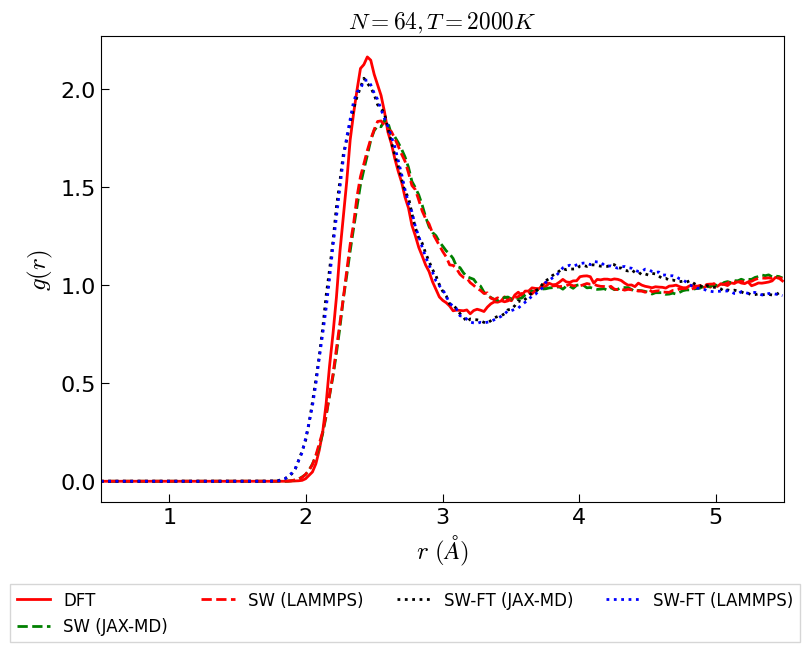

In [24]:
fig, ax = plt.subplots(1, 1,figsize=(8, 6))

ax.set_ylabel(r"$g(r)$",fontsize=18)
ax.set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax.title.set_text(r'$N=64, T=2000K$')
ax.plot(r_mdt_DFT, gr_mdt_DFT, linewidth=2, label='DFT', color='red')
ax.plot(r_mdt, gr_mdt, linewidth=2, label='SW (JAX-MD)', color='green', ls='--')
ax.plot(r_mdt_LAMMPS, gr_mdt_LAMMPS, linewidth=2, label='SW (LAMMPS)', color='red', ls='--')
ax.plot(r_mdt_rdf_ft, gr_mdt_rdf_ft, linewidth=2, label='SW-FT (JAX-MD)', color='black', ls=':')
ax.plot(r_mdt_LAMMPS_rdf_ft, gr_mdt_LAMMPS_rdf_ft, linewidth=2, label='SW-FT (LAMMPS)', color='blue', ls=':')

ax.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax.tick_params(axis="x", direction='in', length=6, labelsize=16)

ax.set_xlim([r[0], r[-1]])

handles_p, labels_p = ax.get_legend_handles_labels()
fig.legend(handles_p,
           labels_p,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.02),
           fancybox=False,
           bbox_transform=fig.transFigure, ncol=4, fontsize=12)

plt.tight_layout()
plt.savefig("final_rdf.pdf", dpi=300,  bbox_inches='tight')
plt.show()

In [25]:
print("---Original parameters---")
for key, value in params.items():
  print(key, value)

---Original parameters---
A 7.116911663877315
B 0.435742506202497
cutoff 3.8164951410728136
epsilon 2.185412158635565
gamma 1.340496813117787
lam 20.799170176269733
sigma 2.0210499784530045


In [26]:
print("---Optimized parameters---")
for key, value in params_si_rdf.items():
  print(key, value)

---Optimized parameters---
A 10.844426990993162
B 0.022466132224308412
cutoff 4.3991878458668054
epsilon 2.4746623997674253
gamma 0.9447606115255649
lam 13.421404161923057
sigma 4.053363951969949


In [27]:
onp.save("radii", r_mdt_DFT)
onp.save("gr_converged", gr_mdt_DFT)
onp.save("gr", gr_mdt)
onp.save("gr_rdf_ft", gr_mdt_rdf_ft)
onp.save("gr_LAMMPS", gr_mdt_LAMMPS)
onp.save("gr_LAMMPS_rdf_ft", gr_mdt_LAMMPS_rdf_ft)

In [29]:
# !zip -r gr_comp.zip /content/gr* /content/radii.npy